# Packages and Constants

In [1]:
from packages.common_imports import *

# Path to the datasets and csv files

The dataset's audio clips are of 6 classes and stored in 6 folders corresponding to each speech command: 
- `ddyo`- `kkono` - `mu maaso` - `emabega` - `yimirira` - `gaali` - `unknown`

In [2]:
from packages.dataset_path import *

## Load sample audio files

In [54]:
# Original audio files
gaali_file_path = os.path.join(train_data_dir, 'gaali', 'gaali_001.wav')

# Pitch scaled audio files
gaali_file_path_pitched = os.path.join(aug_train_data_dir, 'gaali', 'gaali_001np.wav')

# Noisy audio files
gaali_file_path_noisy = os.path.join(aug_train_data_dir, 'gaali', 'gaali_001np.wav')

# Exploratory Data Analysis

## Directory structure

In [8]:
def print_directory_tree(root_dir, indent=''):
    print(indent + os.path.basename(root_dir) + os.path.sep)
    indent += '    '
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            print_directory_tree(item_path, indent)

In [9]:
print_directory_tree(train_data_dir)

Train/
    gaali/
    no_gaali/


In [10]:
print_directory_tree(test_data_dir)

Test/
    gaali/
    no_gaali/


In [11]:
print_directory_tree(aug_train_data_dir)

New_Train/
    gaali/
    no_gaali/


## Labels
- `ddyo`- `kkono` - `mu maaso` - `emabega` - `yimirira` - `unknown`

In [12]:
def list_directory_contents(directory, label):
    contents = np.array(tf.io.gfile.listdir(str(directory)))
    print(f'{label} commands labels: {contents}')
    return contents

In [13]:
train_commands = list_directory_contents(train_data_dir, 'Train')
test_commands = list_directory_contents(test_data_dir, 'Test')

Train commands labels: ['gaali' 'no_gaali']
Test commands labels: ['gaali' 'no_gaali']


## Check audio files
Remove audio files that are
Remove audios that are
- `Duration more than 2 seconds and duration == 0`
- `Audios that do not have mono channel`

and move them to the process folder

In [14]:
def move_and_count_audio_files(data_dir, process_folder):
    try:
        if not os.path.exists(process_folder):
            os.makedirs(process_folder)
        count = 0
        for subfolder in os.listdir(data_dir):
            subfolder_path = os.path.join(data_dir, subfolder)
            if os.path.isdir(subfolder_path):
                for audio_file in os.listdir(subfolder_path):
                    audio_path = os.path.join(subfolder_path, audio_file)
                    try:
                        with wave.open(audio_path, 'r') as wav_file:
                            audio_length = wav_file.getnframes() / wav_file.getframerate()
                            num_channels = wav_file.getnchannels()
                            sample_width = wav_file.getsampwidth()
                        if audio_length > 2.0 or num_channels != 1 or audio_length == 0.0 or sample_width != 2:
                            shutil.move(audio_path, os.path.join(process_folder, audio_file))
                            count += 1
                    except Exception as e:
                        print(f"Error processing {audio_path}: {e}")
                        continue

        print(f"{count} {data_dir} audio files moved to {process_folder}.")
    except Exception as e:
        print(f"An error occurred while moving and counting audio files: {e}")
        return 0

In [16]:
move_and_count_audio_files(train_data_dir, train_data_needs_preprocessing)
move_and_count_audio_files(test_data_dir, test_data_needs_preprocessing)

0 Dataset_WW/Train audio files moved to Dataset_WW/Train_need_preprocessing.
0 Dataset_WW/Test audio files moved to Dataset_WW/Test_need_preprocessing.


## CSV files for the audio files

In [17]:
# Function to create a CSV file for audio files
def create_csv_for_audio_files(data_dir, csv_file_path):
    try:
        with open(csv_file_path, 'w', newline='') as csvfile:
            fieldnames = ['audio_file', 'duration', 'num_channels', 'intent']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for subfolder in os.listdir(data_dir):
                subfolder_path = os.path.join(data_dir, subfolder)
                if os.path.isdir(subfolder_path):
                    for audio_file in os.listdir(subfolder_path):
                        if not audio_file.endswith('.wav'):
                            continue
                        try:
                            with wave.open(os.path.join(subfolder_path, audio_file), 'r') as wav_file:
                                audio_length = wav_file.getnframes() / wav_file.getframerate()
                                num_channels = wav_file.getnchannels()
                            writer.writerow({'audio_file': audio_file, 'duration': audio_length, 'num_channels': num_channels, 'intent': subfolder})
                        except Exception as e:
                            print(f"Error processing {audio_file}: {e}")
                            continue
    except Exception as e:
        print(f"An error occurred while creating CSV file: {e}")

In [18]:
create_csv_for_audio_files(test_data_dir, test_csv_dir)
create_csv_for_audio_files(train_data_dir, train_csv_dir)
create_csv_for_audio_files(aug_train_data_dir, aug_train_csv_dir)

## Number of audio files

### Train dataset

In [19]:
# Function to count the number of audio files in each subfolder of a directory
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    try:
        for subfolder in os.listdir(data_dir):
            subfolder_path = os.path.join(data_dir, subfolder)
            if os.path.isdir(subfolder_path):
                audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
                counts[subfolder] = audio_files_count
                print(f'Total audio files in {subfolder}: {audio_files_count}')
    except Exception as e:
        print(f"An error occurred while processing the directory: {e}")
    return counts

In [20]:
# Plot the counts of audio files in each subfolder
def plot_audio_files_bar(counts, title):
    if not counts:
        print("Error: The input dictionary is empty.")
        return
    try:
        plt.figure(figsize=(12, 5))
        keys, values = list(counts.keys()), list(counts.values())
        bars = plt.bar(keys, values, color='green')
        plt.xlabel('Command labels')
        plt.ylabel('Number of Audio Files')
        plt.title(title)
        plt.grid(False)  # Remove grid lines
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')
        plt.show()
    except Exception as e:
        print(f"Error: {str(e)}")

In [21]:
counts_train = count_audio_files_in_subfolders(train_data_dir)

Total audio files in gaali: 1246
Total audio files in no_gaali: 1394


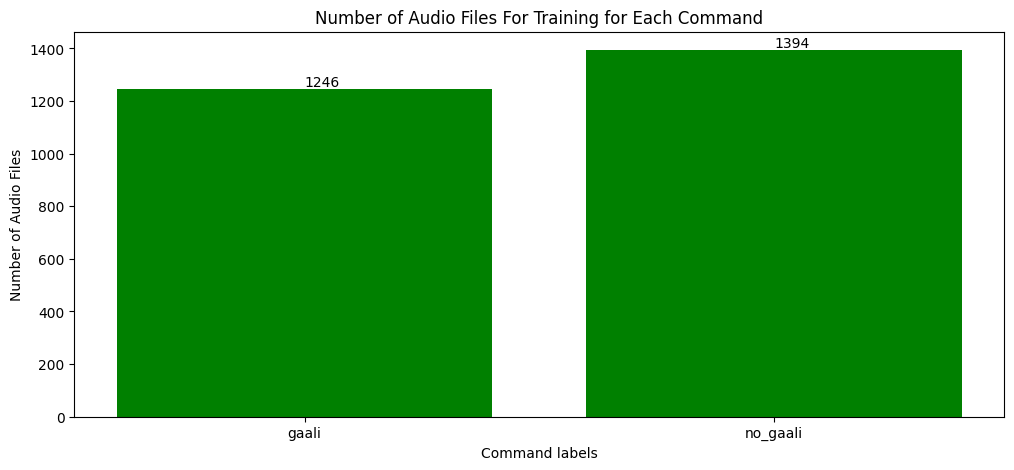

In [22]:
plot_audio_files_bar(counts_train, 'Number of Audio Files For Training for Each Command')

### Test dataset


In [23]:
counts_test = count_audio_files_in_subfolders(test_data_dir)

Total audio files in gaali: 300
Total audio files in no_gaali: 311


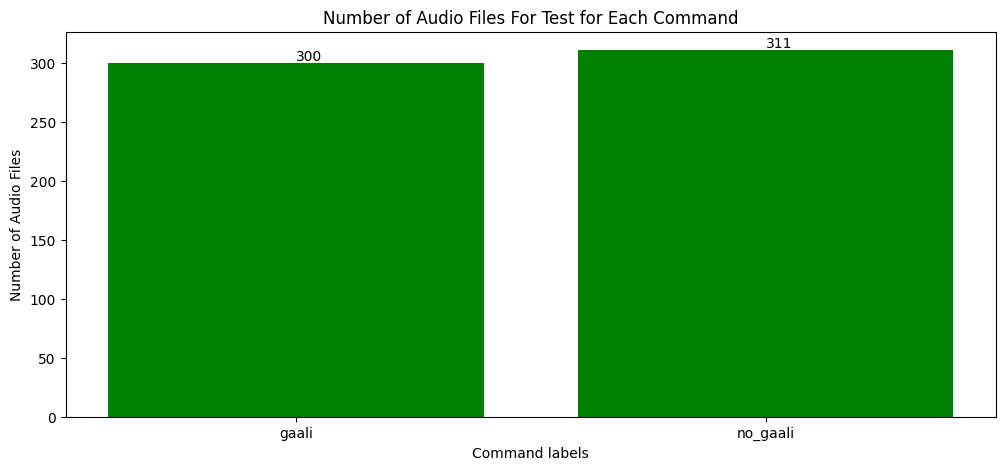

In [24]:
plot_audio_files_bar(counts_test, 'Number of Audio Files For Test for Each Command')

### Augmented dataset

In [25]:
counts_aug_train = count_audio_files_in_subfolders(aug_train_data_dir)

Total audio files in gaali: 2492
Total audio files in no_gaali: 2527


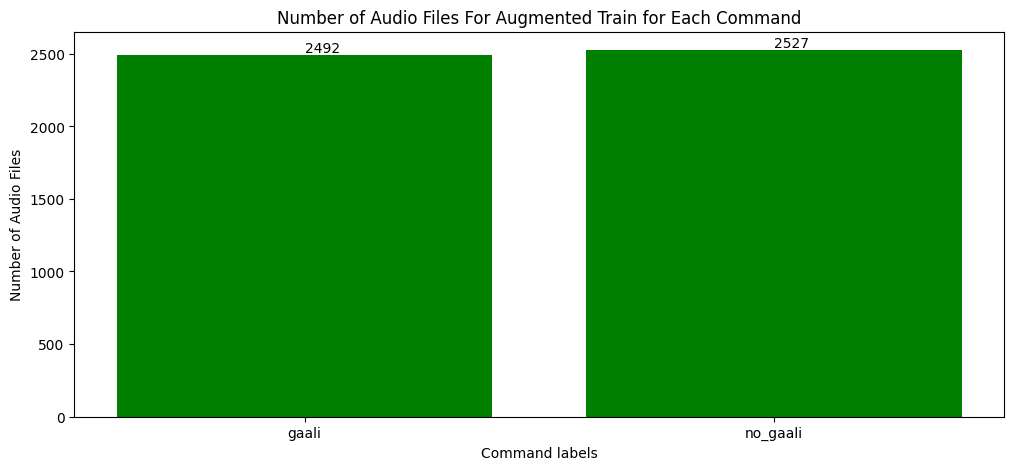

In [26]:
plot_audio_files_bar(counts_aug_train, 'Number of Audio Files For Augmented Train for Each Command')

### Train and Test counts


In [27]:
# Function to plot the count of audio files for training and testing
def plot_audio_files_comparison(train_counts, test_counts):
    if not train_counts or not test_counts:
        print("Error: The input dictionaries are empty.")
        return
    try:
        plt.figure(figsize=(12, 5))
        train_keys, train_values = list(train_counts.keys()), list(train_counts.values())
        test_keys, test_values = list(test_counts.keys()), list(test_counts.values())
        x = np.arange(len(train_keys))
        train_bars = plt.bar(x - 0.2, train_values, 0.4, color='green', label='Train')
        test_bars = plt.bar(x + 0.2, test_values, 0.4, color='purple', label='Test')
        plt.xticks(x, train_keys)
        plt.xlabel('Command labels')
        plt.ylabel('Number of Audio Files')
        plt.title('Number of Audio Files For Training and Testing for Each Command')
        plt.legend()
        for i in range(len(train_bars)):
            plt.text(train_bars[i].get_x(), train_bars[i].get_height(), str(train_values[i]), ha = 'center', va = 'bottom')
            plt.text(test_bars[i].get_x(), test_bars[i].get_height(), str(test_values[i]), ha = 'center', va = 'bottom')
        plt.show()
    except Exception as e:
        print(f"Error: {str(e)}")

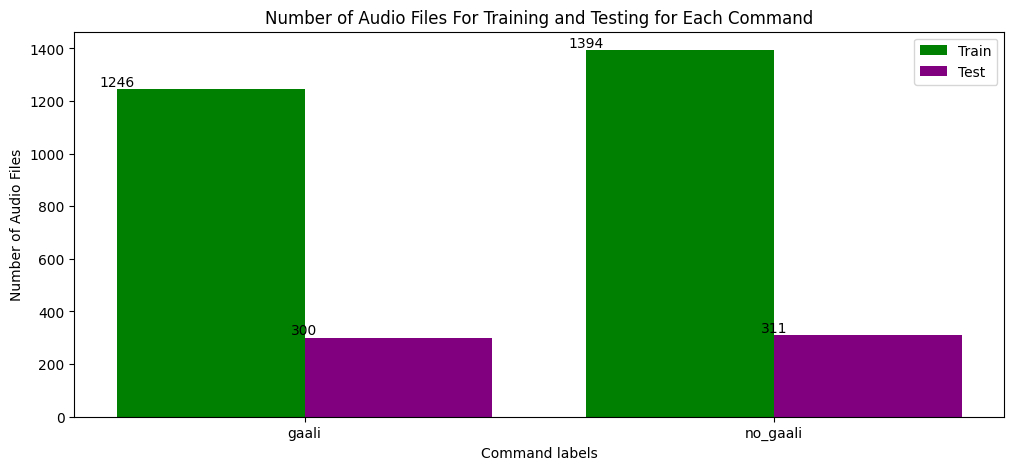

In [28]:
plot_audio_files_comparison(counts_train, counts_test)

### Augmentated Train and Test counts


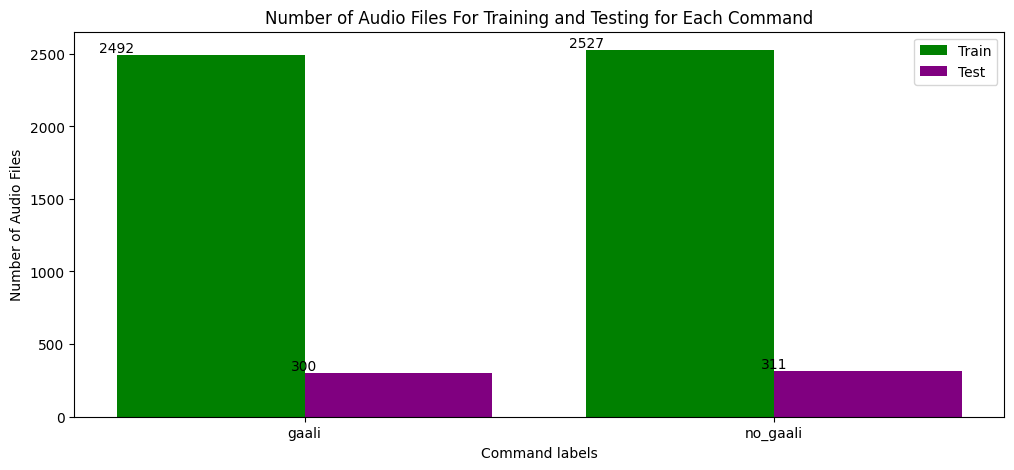

In [29]:
plot_audio_files_comparison(counts_aug_train, counts_test)

## Print the shortest and longeset audio files

In [30]:
# Function to print the shortest and longest audio files in each subfolder of a directory
def print_shortest_and_longest_audio_files(data_dir):
    try:
        for subfolder in os.listdir(data_dir):
            subfolder_path = os.path.join(data_dir, subfolder)
            if os.path.isdir(subfolder_path):
                shortest_audio = None
                longest_audio = None
                shortest_duration = float('inf')
                longest_duration = 0.0
                for audio_file in os.listdir(subfolder_path):
                    audio_path = os.path.join(subfolder_path, audio_file)
                    try:
                        with wave.open(audio_path, 'r') as wav_file:
                            audio_length = wav_file.getnframes() / wav_file.getframerate()
                        if audio_length < shortest_duration:
                            shortest_duration = audio_length
                            shortest_audio = audio_path
                        if audio_length > longest_duration:
                            longest_duration = audio_length
                            longest_audio = audio_path
                    except Exception as e:
                        print(f"Error processing {audio_path}: {e}")
                        continue
                print(f"In {subfolder}:")
                print(f"Shortest audio file: {shortest_audio} with duration: {shortest_duration} seconds")
                print(f"Longest audio file:  {longest_audio}  with duration: {longest_duration} seconds")
                print()
    except Exception as e:
        print(f"An error occurred while processing the directory: {e}")

### Train Dataset

In [31]:
print_shortest_and_longest_audio_files(train_data_dir)

In gaali:
Shortest audio file: Dataset_WW/Train/gaali/gaali_214.wav with duration: 0.011625 seconds
Longest audio file:  Dataset_WW/Train/gaali/gaali_729.wav  with duration: 1.998625 seconds

In no_gaali:
Shortest audio file: Dataset_WW/Train/no_gaali/no_gaali_526.wav with duration: 0.4179375 seconds
Longest audio file:  Dataset_WW/Train/no_gaali/no_gaali_1255.wav  with duration: 2.0 seconds



### Test Dataset

In [32]:
print_shortest_and_longest_audio_files(test_data_dir)

In gaali:
Shortest audio file: Dataset_WW/Test/gaali/gaali_248.wav with duration: 0.307625 seconds
Longest audio file:  Dataset_WW/Test/gaali/gaali_004.wav  with duration: 2.0 seconds

In no_gaali:
Shortest audio file: Dataset_WW/Test/no_gaali/no_gaali_010.wav with duration: 0.464375 seconds
Longest audio file:  Dataset_WW/Test/no_gaali/no_gaali_155.wav  with duration: 2.0 seconds



### Augmentated Train Dataset

In [33]:
print_shortest_and_longest_audio_files(aug_train_data_dir)

In gaali:
Shortest audio file: Dataset_WW/New_Train/gaali/gaali_490.wav with duration: 2.0 seconds
Longest audio file:  Dataset_WW/New_Train/gaali/gaali_490.wav  with duration: 2.0 seconds

In no_gaali:
Shortest audio file: Dataset_WW/New_Train/no_gaali/no_gaali__1095.wav with duration: 2.0 seconds
Longest audio file:  Dataset_WW/New_Train/no_gaali/no_gaali__1095.wav  with duration: 2.0 seconds



## Duration distribution

In [34]:
# Function to plot the distribution of audio lengths
def analyze_audio_duration(data_dir):
    durations = []
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path)
                    duration = librosa.get_duration(y=y, sr=sr)
                    durations.append(duration)
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")
                    continue

    plt.hist(durations, bins=50)
    plt.xlabel('Duration (s)')
    plt.ylabel('Count')
    plt.title('Distribution of Audio Lengths')
    plt.show()

### Train Dataset

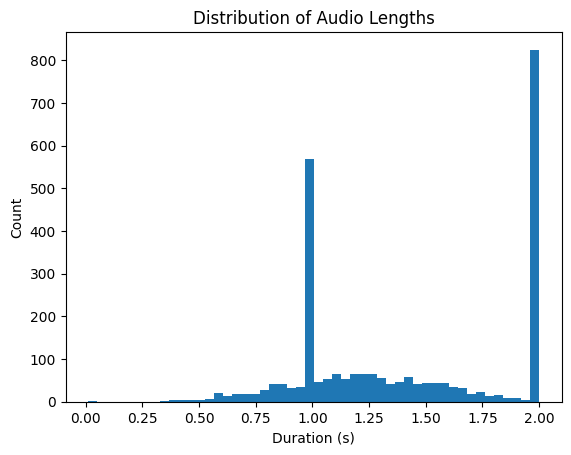

In [35]:
analyze_audio_duration(train_data_dir)

### Test Dataset

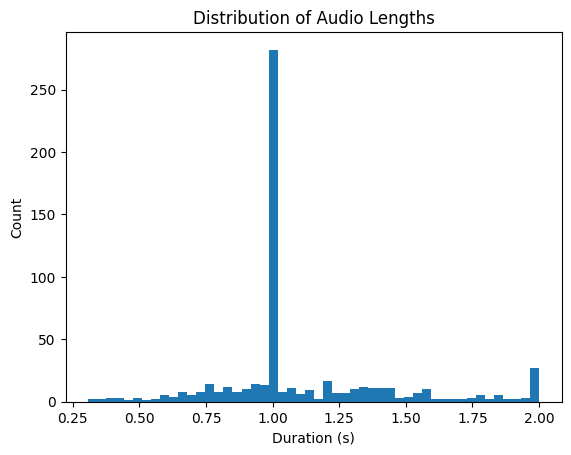

In [36]:
analyze_audio_duration(test_data_dir)

### Augmentated Train Dataset

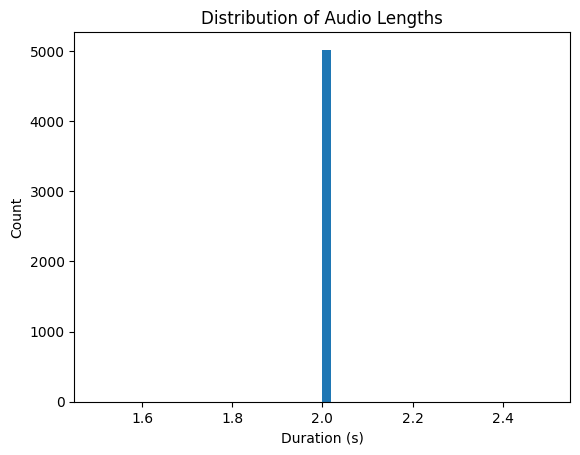

In [37]:
analyze_audio_duration(aug_train_data_dir)

## Audio File Properties and Visualization
- `Number of channels`
- `Sample rate`
- `Duration`
- `Number of frames`

Play the Audio  file

In [50]:
# Function to print audio properties
def print_audio_properties(file_path):
    if not os.path.isfile(file_path):
        print(f"File {file_path} does not exist.")
        return

    try:
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        with wave.open(file_path, 'rb') as audio:
            num_channels = audio.getnchannels()
            frame_rate = audio.getframerate()
            num_frames = audio.getnframes()
            duration = num_frames / float(frame_rate)

            print(f"\nAudio Properties for {os.path.basename(file_path)}")
            print(f"Number of channels:  {num_channels}")
            print(f"Sample rate (Hz):    {sample_rate}")
            print(f"Number of frames:    {num_frames}")
            print(f"Duration (s):        {duration}")
            print()
        
        # Play the audio files
        audio = Audio(file_path)
        display(audio)
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
    return

In [51]:
# Function to display the waveform, mel spectrogram, and MFCC of an audio file
def display_waveform_mel_spectrogram_mfcc(file_path):
    try:
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        time = np.arange(0, len(audio_signal)) / sample_rate
        file_name = os.path.basename(file_path)

        # Plot waveform
        plt.figure(figsize=(18, 6))
        plt.plot(time, audio_signal)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f'Audio Signal Waveform - {file_name}')
        plt.show()

        # Plot mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate)
        plt.figure(figsize=(20, 6))
        img1 = librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(img1, format="%+2.f dB")
        plt.title(f'Mel Spectrogram - {file_name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Mel Frequency')
        plt.show()

        # Plot MFCC
        mfcc = librosa.feature.mfcc(y=audio_signal, sr=sample_rate)
        plt.figure(figsize=(20, 6))
        img2 = librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
        plt.colorbar(img2)
        plt.title(f'MFCC - {file_name}')
        plt.xlabel('Time (s)')
        plt.ylabel('MFCC')
        plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")


### Emabega

In [41]:
print_audio_properties(gaali_file_path)


Audio Properties for gaali_001.wav
Number of channels:  1
Sample rate (Hz):    16000
Number of frames:    15046
Duration (s):        0.940375



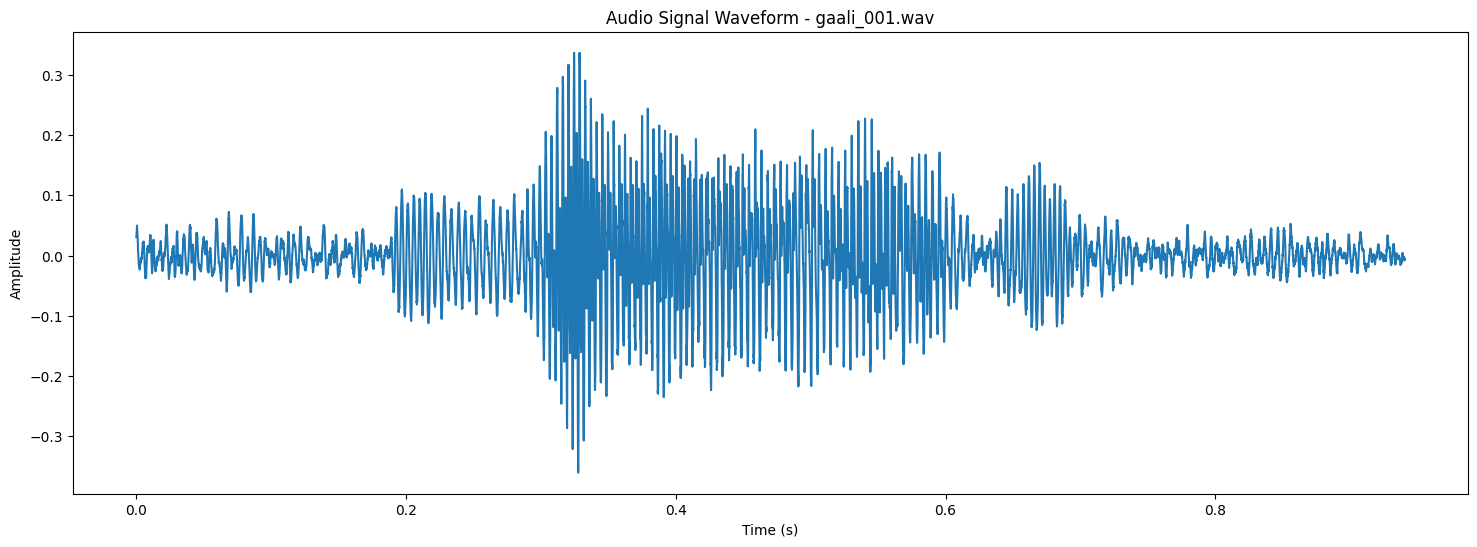

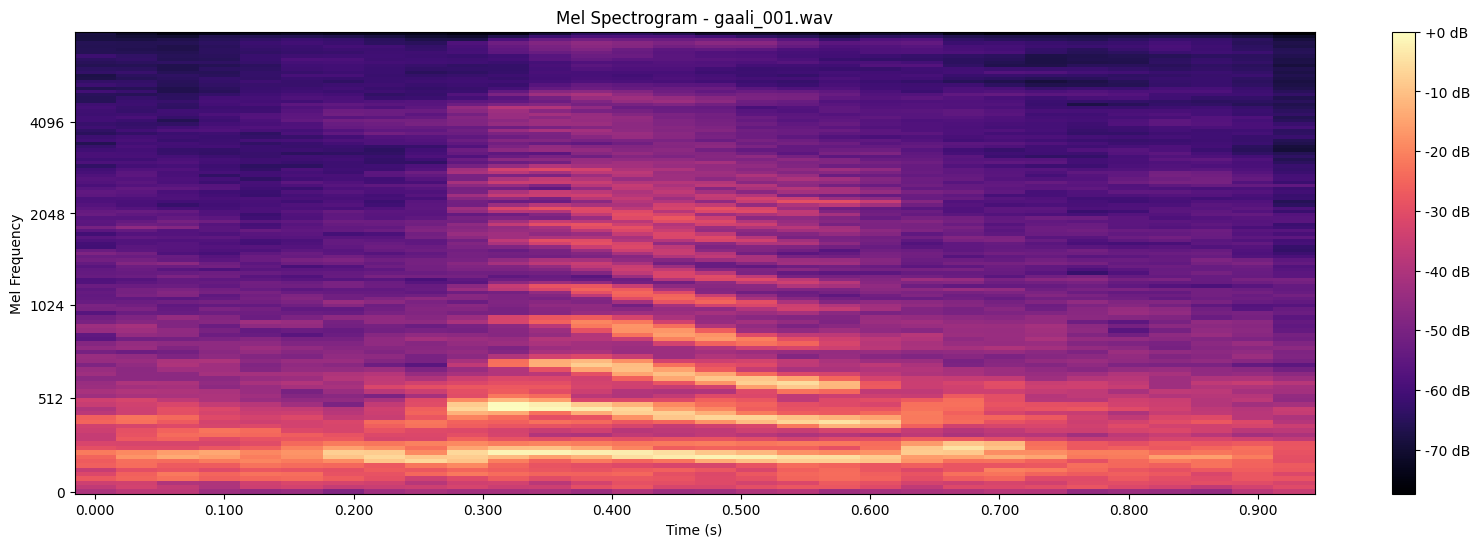

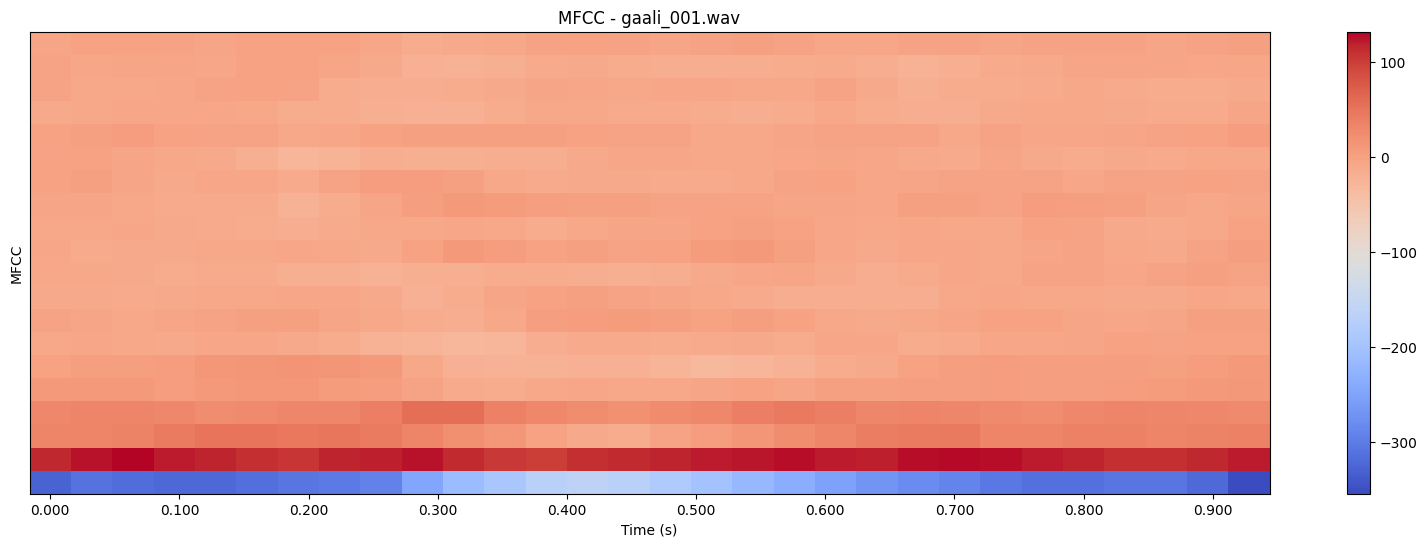

In [43]:
display_waveform_mel_spectrogram_mfcc(gaali_file_path)

# Wave comparison of original and augmentated audio files

In [55]:
def plot_waveforms_comparison(file1, file2, files3):
    # Load audio files
    audio1, sr1 = librosa.load(file1, sr=None)
    audio2, sr2 = librosa.load(file2, sr=None)
    audio3, sr3 = librosa.load(files3, sr=None)

    # Create time axis
    time1 = librosa.times_like(audio1, sr=sr1)
    time2 = librosa.times_like(audio2, sr=sr2)
    time3 = librosa.times_like(audio3, sr=sr3)

    # Plot waveform of audio1
    plt.figure(figsize=(20, 6))
    plt.plot(time1, audio1)
    plt.title('Original audio waveplot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Plot waveform of audio2
    plt.figure(figsize=(20, 6))
    plt.plot(time2, audio2)
    plt.title('Pitched audio waveplot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Plot waveform of audio3
    plt.figure(figsize=(20, 6))
    plt.plot(time3, audio3)
    plt.title('Noisy audio waveplot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

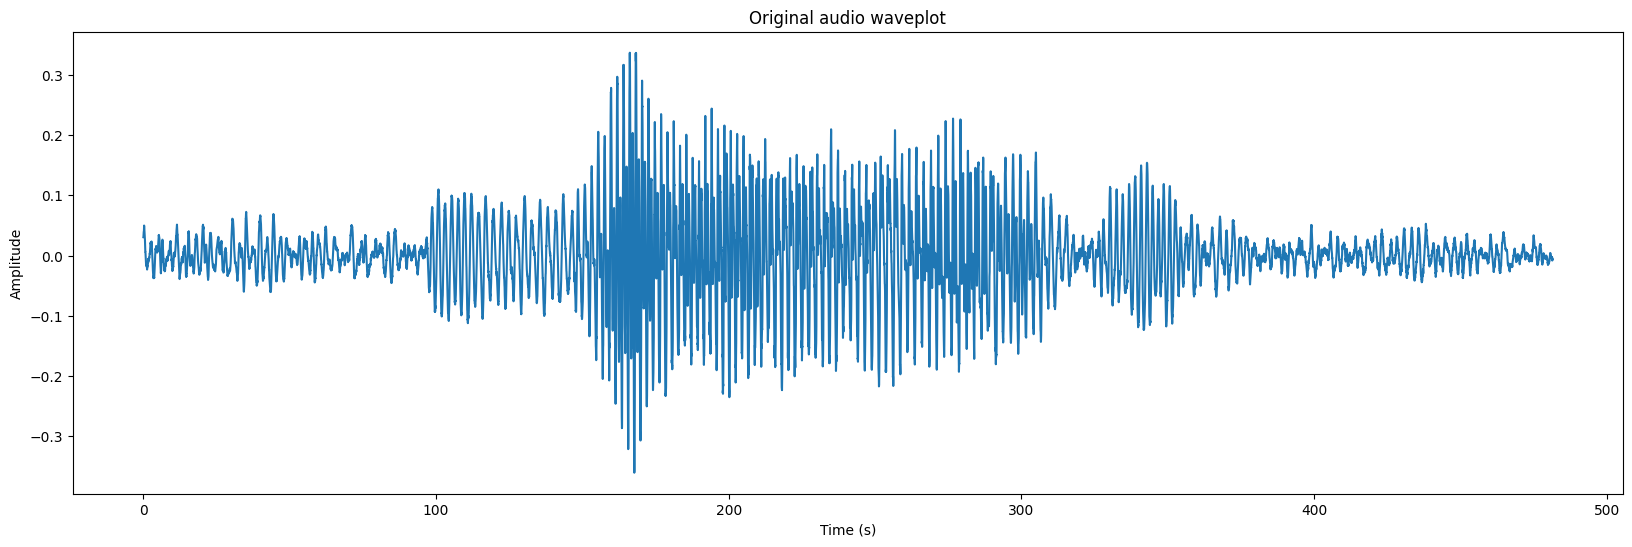

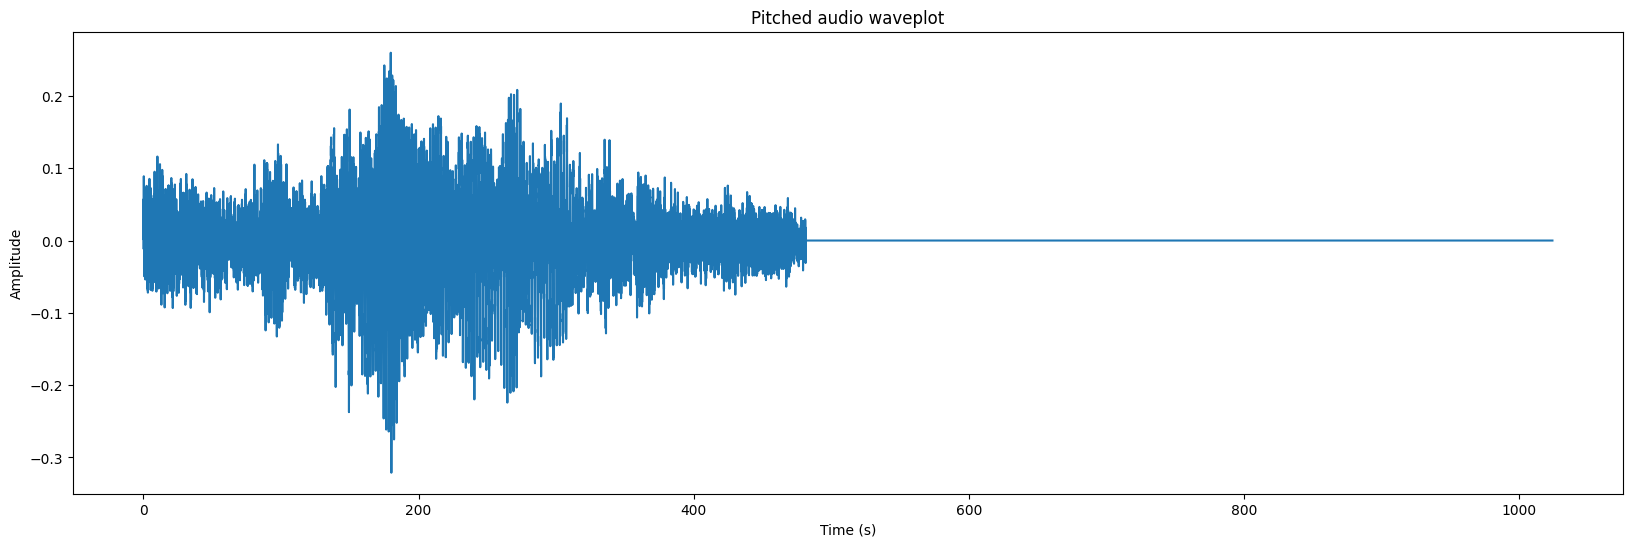

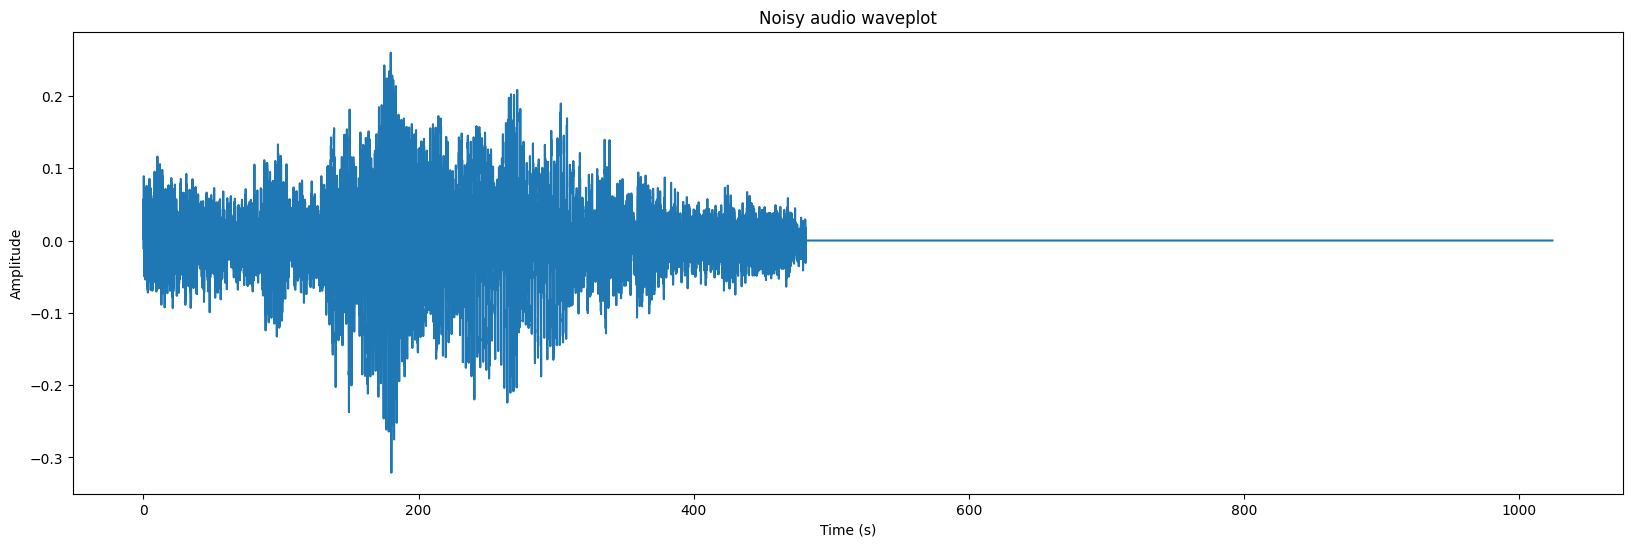

In [56]:
plot_waveforms_comparison(gaali_file_path, gaali_file_path_pitched, gaali_file_path_noisy)